## Price and Size

In [2]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In [6]:
def wrangle(filepath):
    # read excel file into dataframe
    df = pd.read_excel(filepath)
    
    # subset to properties in "Capital Federal"
    mask_ba = df['place_with_parent_names'].str.contains("Capital Federal")
    
    #subset to "apartments"
    mask_apt = df['property_type'] == "apartment"
    
    # subset to properties where "price_aprox_usd" < 400,000
    mask_price = df['price_aprox_usd'] < 400_000
    
    # SUBSET
    df=df[mask_ba & mask_apt & mask_price]
    
    # remove outliers by "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    
    df = df[mask_area]
    return df

In [7]:
df = wrangle("/content/data_1.xlsx")
print("df shape:", df.shape)
df.head()

df shape: (1343, 17)


,Unnamed: 0,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,5,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,10,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,30,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,41,sell,apartment,|Argentina|Capital Federal|Constitución|,"-34.6252219,-58.3823825",57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...
41,42,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...


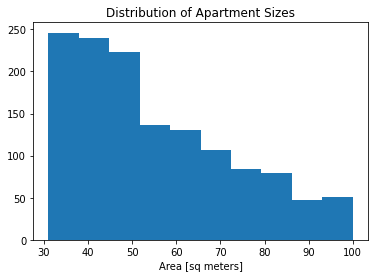

In [8]:
plt.hist(df["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Apartment Sizes");

In [9]:
df.describe()["surface_covered_in_m2"]

count    1343.000000
mean       55.076694
std        18.160427
min        31.000000
25%        40.000000
50%        50.000000
75%        68.500000
max       100.000000
Name: surface_covered_in_m2, dtype: float64

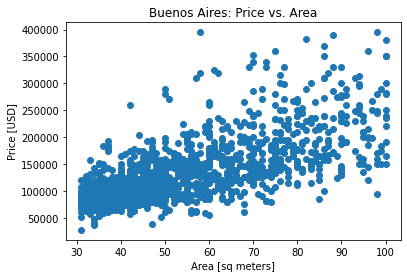

In [10]:
plt.scatter(x=df["surface_covered_in_m2"], y=df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs. Area");

In [11]:
features = ["surface_covered_in_m2"]
X_train = df[features]
X_train.shape

(1343, 1)

In [12]:
target = "price_aprox_usd"
y_train = df[target]
y_train.shape


(1343,)

In [13]:
y_mean = y_train.mean()
y_mean

135527.83871928515

In [14]:
y_pred_baseline = [y_mean]*len(y_train)

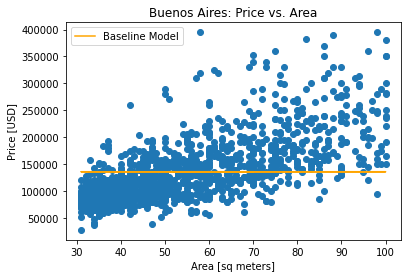

In [15]:
plt.plot(X_train, y_pred_baseline, color="orange", label="Baseline Model")
plt.scatter(X_train, y_train)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs. Area")
plt.legend();

In [16]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 135527.84
Baseline MAE: 45199.46


In [19]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [18]:
check_is_fitted(model)

In [20]:
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([169151.87330223, 106064.44707446, 133101.91545779, 106064.44707446,
       124089.42599668])

In [21]:
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 31248.26


In [23]:
X_test = pd.read_excel("/features.xlsx")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    117330.058901
1    135355.037823
2     88039.468152
3     88039.468152
4    106064.447074
dtype: float64

In [24]:
intercept = round(model.intercept_,2)
print("Model Intercept:", intercept)
assert any([isinstance(intercept, int), isinstance(intercept, float)])

coefficient = round(model.coef_[0], 2)
print('Model coefficient for "surface_covered_in_m2":', coefficient)
assert any([isinstance(coefficient, int), isinstance(coefficient, float)])

Model Intercept: 11433.31
Model coefficient for "surface_covered_in_m2": 2253.12


In [25]:
print(f"apt_price = {intercept} + {coefficient} * surface_covered")

apt_price = 11433.31 + 2253.12 * surface_covered


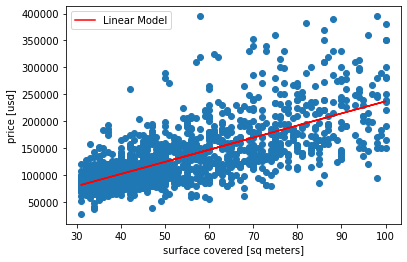

In [26]:
plt.plot(X_train, model.predict(X_train), color="red", label="Linear Model")
plt.scatter(X_train, y_train)
plt.xlabel("surface covered [sq meters]")
plt.ylabel("price [usd]")
plt.legend();